In [2]:
import pandas as pd
import numpy as np
from PyALE import ale
import joblib
from sklearn.preprocessing import OneHotEncoder

In [12]:
xgb = joblib.load("models/XGBClassifier_ohe_mode_allcat.pkl")
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_ohe = pd.read_csv("data/ohe_mode_allcat.csv")

ohe_col = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp']

In [13]:
df_ohe.drop(columns=['Unnamed: 0'],inplace=True)

In [14]:
# df transformation
df['temperature'] = df['temperature'].astype(object)
change_row = ['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']
for i in change_row:
    df[i] = f'{i}_' + df[i].astype(str)

In [15]:
from pyale import hyeni_pyale

PyALE._ALE_generic:INFO: categorical feature detected.


,eff,size,lowerCI_95%,upperCI_95%
coupon,,,,
Coffee House,0.174781,3996,NaN,NaN
Restaurant(<20),-0.005402,2786,-0.014569,0.003766
Carry out & Take away,-0.211812,2393,-0.225048,-0.198577
Restaurant(20-50),-0.105506,1492,-0.122465,-0.088546
Bar,-0.009467,2017,-0.023611,0.004677


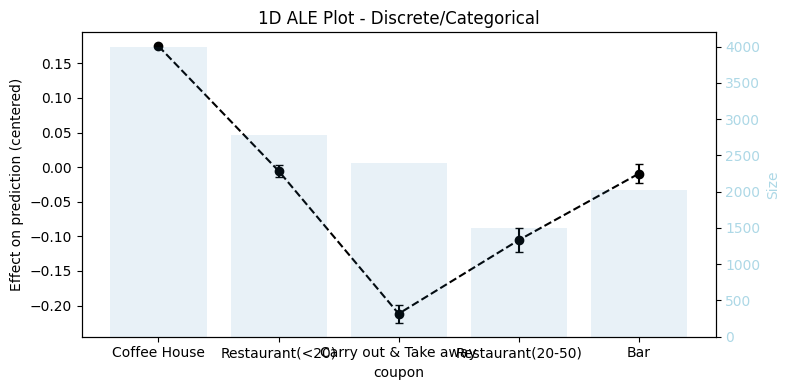

In [18]:
hyeni_pyale(df,df_ohe,xgb,'coupon')